In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.numpy import rmse
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, VecToScalarFeed, gen_added_strings

In [23]:
dimensions = 32
n_neurons = 500
seed = 8

n_items = 5

t_present = 0.3
t_pause = 0.3
t_each = t_pause + t_present
dt = 0.001

In [24]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [25]:
all_fan = fan1 + fan2
all_fan_pairs = gen_added_strings(all_fan)

all_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

target_ans = [1] * (len(fan1) + len(fan2))
foil_ans = [-1] * (len(foil1) + len(foil2))
all_ans = target_ans + foil_ans

# IA opt

## Base case

In [72]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network(seed=seed) as base_model:
    base_model.famili = nengo.Node(feed.feed)
    base_model.correct = nengo.Node(feed.get_answer)
    base_model.reset = nengo.Node(lambda t: feed.paused)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    base_model.cleanup = spa.IAAssocMem(input_vocab=vocab, mapping=dict(zip(all_fan_pairs, all_fan_pairs)))
    
    nengo.Connection(base_model.famili, base_model.cleanup.input, synapse=None)
    nengo.Connection(base_model.reset, base_model.cleanup.input_reset, synapse=None)
    
    base_model.p_in = nengo.Probe(base_model.famili, synapse=None, label="input")
    base_model.p_accum = nengo.Probe(base_model.cleanup.selection.accumulators.output, synapse=0.01, label="accum")
    base_model.p_clean = nengo.Probe(base_model.cleanup.output, synapse=0.01, label="clean")

In [73]:
with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = base_sim.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


In [74]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

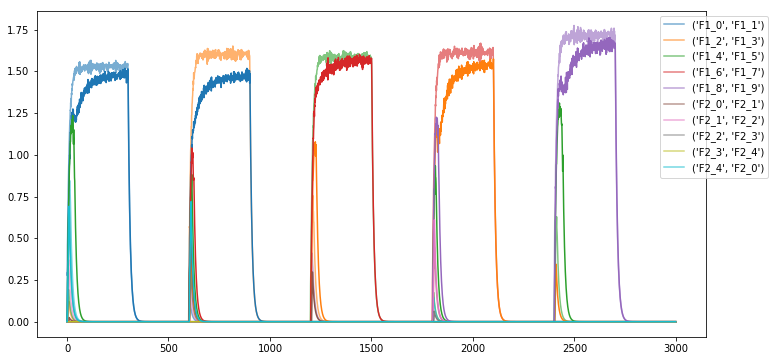

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(base_sim.data[base_model.p_accum][fan1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(base_sim.data[base_model.p_accum][foil1_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

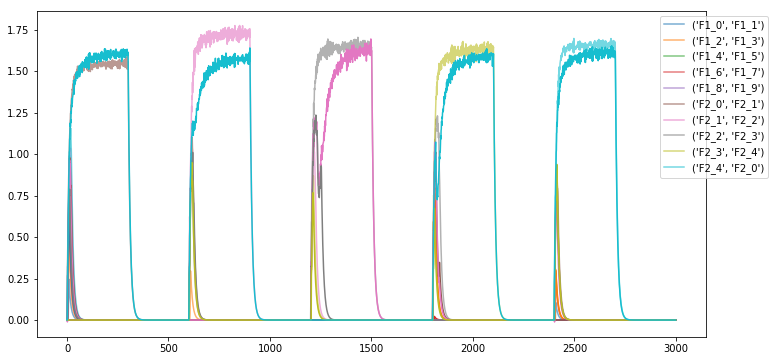

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(base_sim.data[base_model.p_accum][fan2_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(base_sim.data[base_model.p_accum][foil2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

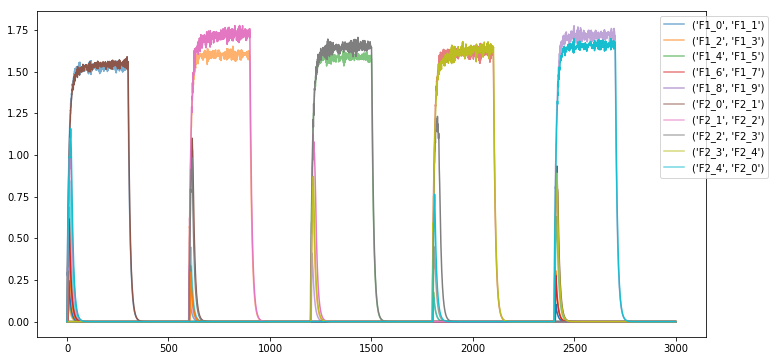

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(base_sim.data[base_model.p_accum][fan1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(base_sim.data[base_model.p_accum][fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

## Higher output thresh

Does basically nothing and would require a lot of fine tuning to get rid of the spike.

In [53]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network(seed=seed) as thresh_model:
    thresh_model.famili = nengo.Node(feed.feed)
    thresh_model.correct = nengo.Node(feed.get_answer)
    thresh_model.reset = nengo.Node(lambda t: feed.paused)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    thresh_model.cleanup = spa.IAAssocMem(input_vocab=vocab, mapping=dict(zip(all_fan_pairs, all_fan_pairs)), accum_threshold=1.3)
    
    nengo.Connection(thresh_model.famili, thresh_model.cleanup.input, synapse=None)
    nengo.Connection(thresh_model.reset, thresh_model.cleanup.input_reset, synapse=None)
    
    thresh_model.p_in = nengo.Probe(thresh_model.famili, synapse=None, label="input")
    thresh_model.p_accum = nengo.Probe(thresh_model.cleanup.selection.accumulators.output, synapse=0.01, label="accum")
    thresh_model.p_clean = nengo.Probe(thresh_model.cleanup.output, synapse=0.01, label="clean")

In [54]:
with nengo.Simulator(thresh_model) as thresh_sim:
    thresh_sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = thresh_sim.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


In [55]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

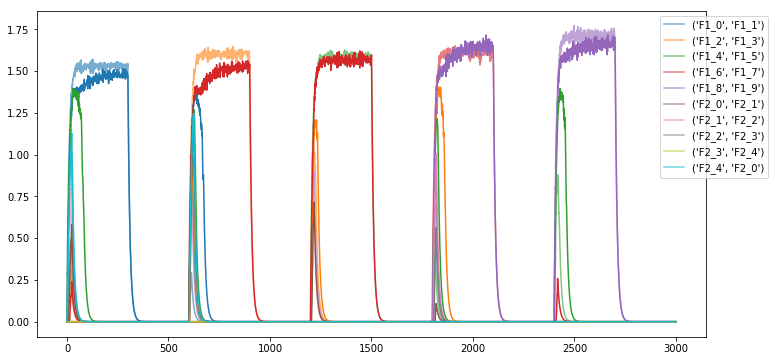

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(thresh_sim.data[thresh_model.p_accum][fan1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(thresh_sim.data[thresh_model.p_accum][foil1_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

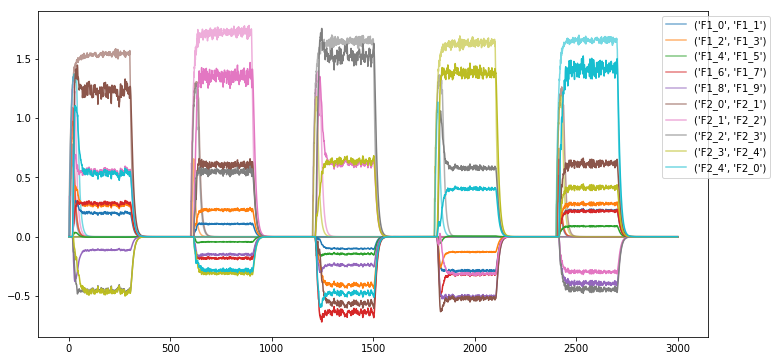

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(thresh_sim.data[thresh_model.p_accum][fan2_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(thresh_sim.data[thresh_model.p_clean], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

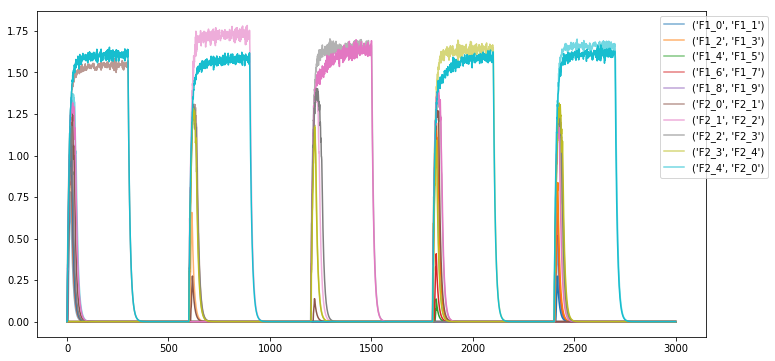

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(thresh_sim.data[thresh_model.p_accum][fan2_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(thresh_sim.data[thresh_model.p_accum][foil2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

## Fast accum

In [60]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network(seed=seed) as fast_model:
    fast_model.famili = nengo.Node(feed.feed)
    fast_model.correct = nengo.Node(feed.get_answer)
    fast_model.reset = nengo.Node(lambda t: feed.paused)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    fast_model.cleanup = spa.IAAssocMem(input_vocab=vocab, mapping=dict(zip(all_fan_pairs, all_fan_pairs)), accum_timescale=0.1)
    
    nengo.Connection(fast_model.famili, fast_model.cleanup.input, synapse=None)
    nengo.Connection(fast_model.reset, fast_model.cleanup.input_reset, synapse=None)
    
    fast_model.p_in = nengo.Probe(fast_model.famili, synapse=None, label="input")
    fast_model.p_accum = nengo.Probe(fast_model.cleanup.selection.accumulators.output, synapse=0.01, label="accum")
    fast_model.p_clean = nengo.Probe(fast_model.cleanup.output, synapse=0.01, label="clean")

In [61]:
with nengo.Simulator(fast_model) as fast_sim:
    fast_sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = fast_sim.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


In [55]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

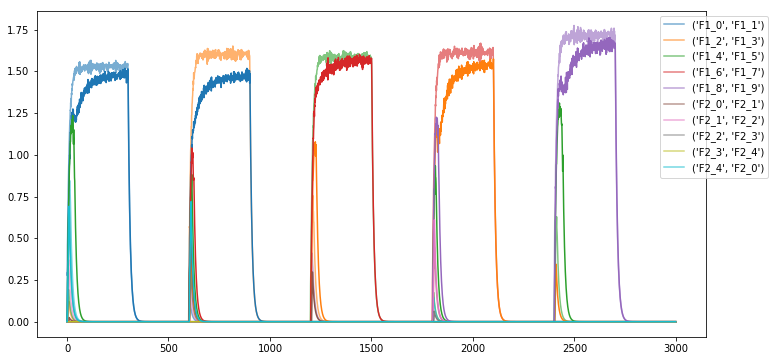

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(fast_sim.data[fast_model.p_accum][fan1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(fast_sim.data[fast_model.p_accum][foil1_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

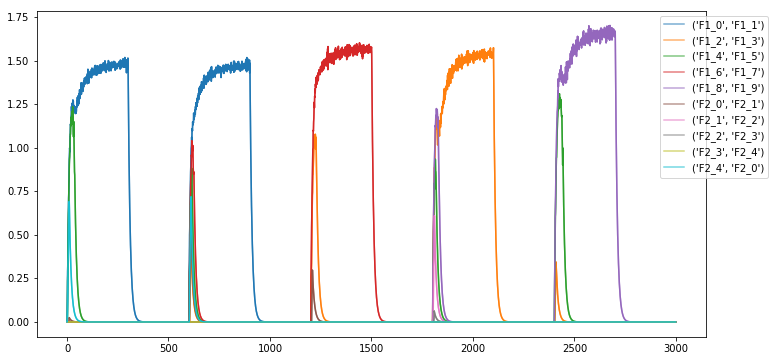

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(base_sim.data[base_model.p_accum][foil1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(fast_sim.data[fast_model.p_accum][foil1_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

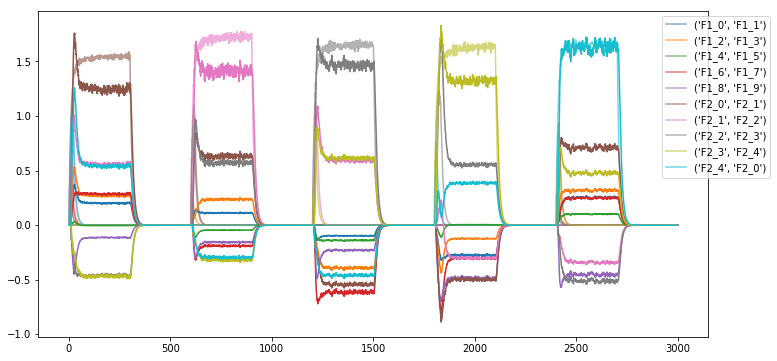

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(fast_sim.data[fast_model.p_accum][fan2_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(fast_sim.data[fast_model.p_clean], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

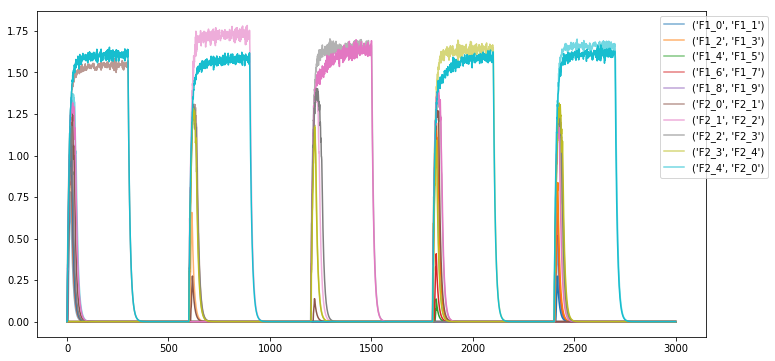

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(thresh_sim.data[thresh_model.p_accum][fan2_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(thresh_sim.data[thresh_model.p_accum][foil2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

## Slow accum

## Fast accum

In [66]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network(seed=seed) as slow_model:
    slow_model.famili = nengo.Node(feed.feed)
    slow_model.correct = nengo.Node(feed.get_answer)
    slow_model.reset = nengo.Node(lambda t: feed.paused)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    slow_model.cleanup = spa.IAAssocMem(input_vocab=vocab, mapping=dict(zip(all_fan_pairs, all_fan_pairs)), accum_timescale=0.3)
    
    nengo.Connection(slow_model.famili, slow_model.cleanup.input, synapse=None)
    nengo.Connection(slow_model.reset, slow_model.cleanup.input_reset, synapse=None)
    
    slow_model.p_in = nengo.Probe(slow_model.famili, synapse=None, label="input")
    slow_model.p_accum = nengo.Probe(slow_model.cleanup.selection.accumulators.output, synapse=0.01, label="accum")
    slow_model.p_clean = nengo.Probe(slow_model.cleanup.output, synapse=0.01, label="clean")

In [67]:
with nengo.Simulator(slow_model) as slow_sim:
    slow_sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = slow_sim.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


In [55]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

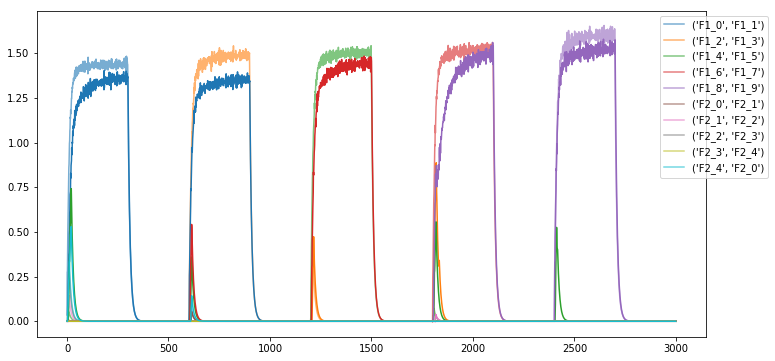

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(slow_sim.data[slow_model.p_accum][fan1_win], alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(slow_sim.data[slow_model.p_accum][foil1_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

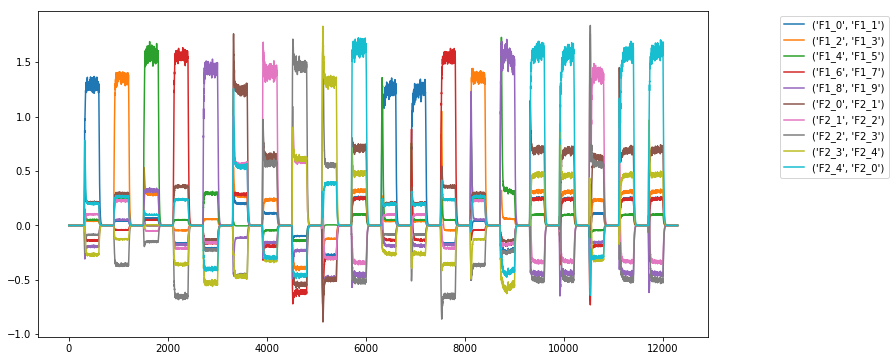

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(spa.similarity(fast_sim.data[fast_model.p_clean], fan1_pair_vecs+fan2_pair_vecs))
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

# Vector output opt